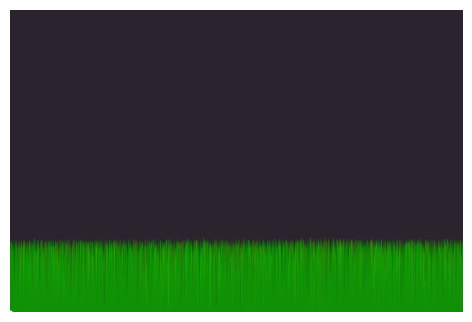

In [47]:
#!/usr/bin/python3.7
#Sunset_grasslands.ipynb
#Parth Parakh
#purpose: based on code by Mianzhi Wang in Matlab
#---------------------------------------------------------------------
#import modules
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.cm as cm
import matplotlib as mpl
from cycler import cycler
from scipy import fft
from scipy import interpolate
#----------------------------------------------------------------------
#helper function
def payoff(x,xi,alpha,K,L,U,C,call):
    #Scale
    S = C*np.exp(x);
    g = np.zeros(len(x))
    #Payoff 
    if call == 1:
        for i in range(0,len(x)):
            # see e.g. Green, Fusai, Abrahams 2010, Eq. (3.24)
            g[i] = np.exp(alpha*x[i])*max(S[i]-K,0)*(S[i]>=L)*(S[i]<=U);

    #Analytical Fourier transform of the payoff
    l = np.log(L/C); # lower log barrier
    k = np.log(K/C); # log strike
    u = np.log(U/C); # upper log barrier

    #Integration bounds
    if call == 1:
        # call
        a = max(l,k);
        b = u;
    else:
        #put
        a = min(k,u);
        b = l;

    #Green, Fusai, Abrahams 2010 Eq. (3.26) with extension to put option
    xi2 = alpha+1j*xi;
    G = C*((np.exp(b*(1+xi2))-np.exp(a*(1+xi2)))/(1+xi2) - (np.exp(k+b*xi2)-np.exp(k+a*xi2))/xi2);

    #Eliminable discontinuities for xi = 0, otherwise 0/0 = NaN
    return S,g,G

def Fourier_Transform(xwidth,ngrid,alpha,sigma,S0,K,muRN,T,r):
    N = ngrid/2;
    b = xwidth/2; #upper bound of the support in real space
    dx = xwidth/ngrid;
    x = dx*np.arange(-N,N);
    dxi = 2*np.pi/xwidth; #Nyquist relation
    xi = dxi*np.arange(-N,N);

    # Characteristic function at time T
    xia = xi+1j*alpha; #call
    psi = 1j*muRN*xia-0.5*(sigma*xia)**2; #characteristic exponent
    Psic = np.exp(psi*T); #characteristic function
    xia = xi-1j*alpha; #put
    psi = 1j*muRN*xia-0.5*(sigma*xia)**2; #characteristic exponent
    Psip = np.exp(psi*T); #characteristic function

    U = S0*np.exp(b);
    L = S0*np.exp(-b);

    S,gc,Gc = payoff(x,xi,alpha,K,L,U,S0,1); #call

    # Discounted expected payoff computed with the Plancherel theorem
    c = np.exp(-r*T)*np.real(fft.fftshift(fft.fft(fft.ifftshift(Gc*np.conjugate(Psic)))))/xwidth; # call
    tck = interpolate.splrep(S, c)
    VcF = interpolate.splev(S0, tck)
    
    return VcF;

#PLOT_MOUNTAINS : Plots mountains.
def plot_mountains():
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['g','Lime','Olive','ForestGreen','DarkGreen']) 
    fig,ax = plt.subplots(1,figsize=(7,4), dpi=100)
    #ax.imshow()
    canvas_width = 1200;
    canvas_height = 800;

    #generation parameters
    base_sin_period = 1.0 * canvas_width;           # controls the number of summits
    base_amp = 0.14 * canvas_height;                # controls altitude variation
    base_noise_var = 4;                             # controls the noise strength
    decay = 0.8;                                    # controls the decaying factor for farther mountains
    n_mountain = 8;                                 # no of mountains
    #color configurations
    mountain_color = [216,171,132];
    mountain_color[:] = [x / 255 for x in mountain_color]
    sun_center_color = [254,243,105]
    sun_center_color[:] = [x / 255 for x in sun_center_color]
    sun_edge_color = [248,130,6];
    sun_edge_color[:] = [x / 255 for x in sun_edge_color]
    sky_color = [48,25,52];
    sky_color[:] = [x / 255 for x in sky_color]
     
    #draw the background (sky)
    rect = patches.Rectangle((0,0),canvas_width,canvas_height,linewidth=0,edgecolor='none',facecolor=sky_color)
    ax.add_patch(rect)
    
    K = np.random.standard_normal(5);
    
    color = [0,0,0];
    sigmaT = [0.10,0.20,0.28]
    #draw the mountains, from the farthest one to the nearest one
    for sigma in sigmaT:
        for ii in range(1,n_mountain):
            y = ii / (n_mountain + 3) * canvas_height;
            # give lighter colors for farther mountains
            color[:] = [x*(ii/n_mountain/1.5) for x in mountain_color]
            # reduce the amount of superimposed Brownian motion and noise for father
            # mountains
            amp = base_amp*(decay**(ii - 1));
            noise_var = base_noise_var*(decay**(ii - 1));
            # give more summits to farther mountains
            sin_period = base_sin_period * (1.0 - (ii - 1) / n_mountain);
            draw_mountain_range(y, sin_period, amp, noise_var, 800, color,canvas_height,canvas_width,sigma);
    
    #draw the sunlight
    sun = draw_sunlight(sun_center_color, sun_edge_color, 0.03,canvas_height,canvas_width);
    
    ax.add_patch(sun)
    # update axis config
    plt.axis('scaled')
    plt.axis('off')
    plt.plot(K,color='white')
    fig.patch.set_visible(False)
    plt.xlim(0,canvas_width)
    plt.ylim(0,canvas_height) 
    plt.show()

def draw_mountain_range(y, sin_period, amp, noise_var, n, color,canvas_height,canvas_width,sigma): 
    
    bm_ratio = 0.15;                                # controls the amplitude of the Brownian motion 
    x_grid = np.linspace(0,canvas_width, num=n);
    phase_offset = (y / canvas_height) * 4 * np.pi;
    thetas = x_grid * 2 * np.pi / sin_period;
    # use the sum of two sine functions as the base curve
    base = np.sin(phase_offset + thetas);
    base = base + np.sin(phase_offset + 0.3 * thetas);
    base = base * amp;
    # add Brownian motion
    
    #bm = np.cumsum(np.sqrt(bm_ratio * amp) * np.random.normal(0,1,(1, n)));
    # add Gaussian noise
    #final_curve = y + base + bm + noise_var * np.random.normal(0,1,(1, n));
    #Defining the parameters
    T = 1; # maturity
    S0 = 200; # spot price
    #K = 110; #strike price
    r = 0.05; #risk-free interest rate
    q = 0.02; # dividend rate
    # Fourier parameters
    xwidth = 6; # width of the support in real space
    ngrid = 2**8; #number of grid points
    alpha = -10; #damping factor for a call
    muRN = r-q-0.5*sigma**2;
    
    K = np.random.exponential(2/3,(800,1))*110;
    final_curve = np.zeros(800);
    for i in range(0,800):
        final_curve[i] = Fourier_Transform(xwidth,ngrid,alpha,sigma,S0,K[i],muRN,T,r);
    #print(len(final_curve))
    
    #plot1 = plt.figure(1,figsize=(7,4), dpi=100)
    #plt.plot(final_curve)
    
    a = np.array([0,0]).reshape((1,2))
    b = np.transpose(x_grid).reshape((800,1))
    c = np.transpose(final_curve).reshape((800,1))
    d = np.concatenate((b,c),axis=1)
    e = np.array([canvas_width,0]).reshape((1,2))
    vertices = np.concatenate((a,d,e,a),axis=0);  
    # prepare vertices for the fill functions
    # draw the current mountain
    plt.fill(vertices[:,0],vertices[:,1],color,alpha=0.3);                      

def draw_sunlight(c_color, e_color, randomness,canvas_height,canvas_width):
    n_tri = 20; #number of triangles
    theta = np.linspace(-np.pi/2,0,n_tri+1);
    theta = np.transpose(theta);                          
    diag_length = np.sqrt(canvas_height**2 + canvas_width**2);
    # adding some randomness to the radius to mimic the effect of sunlight
    a = randomness*np.random.standard_normal((n_tri + 1, 1))
    for i in range(0,n_tri+1):
        a[i] = min(a[i],1)
        a[i] = max(a[i],-1)
        
    radius = diag_length * (1.0 + a[i] );
    # building the drawing parameters for patch

    #Ar.FaceColor = "interp";
    #Ar.FaceAlpha = 'interp';
    
    a = np.array([[0,canvas_height]])
    b = np.array([radius*np.cos(theta),canvas_height+radius*np.sin(theta)])
    Vertices = np.concatenate((a,np.transpose(b)),axis = 0);
    
    #print(np.shape(Ar.Vertices))
    
    a = np.arange(3,(n_tri+3)).reshape((20,1));
    b = np.arange(2,(n_tri+2)).reshape((20,1));
    c = np.ones((n_tri,1));
    Faces = np.concatenate((c,a,b),axis=1);
    
    #print(np.shape(Ar.Faces))
      
    a = np.transpose(np.tile(e_color,(n_tri+1,1)))
    b = np.array(c_color).reshape(3,1);
    c = np.concatenate((a,b),axis=1)
    #Ar.FaceVertexCData = np.concatenate(c);
    
    #print(np.shape(Ar.FaceVertexCData))
    
    a = 0.0*np.ones((n_tri+1,1))
    b = np.array([1]).reshape(1,1)
    #Ar.FaceVertexAlphaData = np.concatenate((b,a),axis=0);

    #print(np.shape(Ar.FaceVertexAlphaData))
    polygon = Polygon(Vertices,alpha=0.1)
    #sun = patches.Patch(edgecolor=Ar.Vertices, facecolor=Ar.FaceVertexCData, alpha=Ar.FaceVertexAlphaData)
     
    return polygon;
if __name__ == "__main__":
    plot_mountains()